In [43]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sn
import warnings

# Suppress specific non-actionable warnings for a cleaner notebook output
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue` is deprecated")
warnings.filterwarnings("ignore", message="Could not infer format")

# Avoid pandas SettingWithCopyWarning in this notebook; use .loc or suppress explicitly
pd.options.mode.chained_assignment = None

In [ ]:
# Inspect data columns and sample rows
url = "https://raw.githubusercontent.com/sjhawkins24/ap-rankings-scrape/refs/heads/main/CollegeFootballRankings24to20.csv"
data = pd.read_csv(url)
print("Columns:", list(data.columns))
print('\nSample rows:')
print(data.head().to_string(index=False))

# Show unique values for AP/CFP
print('\nAP/CFP value counts:')
print(data['AP/CFP'].value_counts(dropna=False).head(20))

# Convert AP/CFP to numeric where possible
import re

def parse_rank(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    x = str(x).strip()
    if x == '--' or x == '—':
        return np.nan
    # extract first integer
    m = re.search(r"(\d+)", x)
    return int(m.group(1)) if m else np.nan

# create AP_rank and ensure numeric dtype
data['AP_rank'] = data['AP/CFP'].apply(parse_rank)
data['AP_rank'] = pd.to_numeric(data['AP_rank'], errors='coerce')
print('\nConverted AP_rank sample:')
print(data[['AP/CFP','AP_rank']].head().to_string(index=False))

# Save back a small filtered frame for plotting (only numeric ranks)
data_filtered = data[data['AP_rank'].notna()].copy()
print('\nFiltered rows (with numeric rank):', data_filtered.shape[0])

Columns: ['Team', 'date', 'opponent', 'win_loss', 'pass', 'rush', 'rec', 'points_allowed', 'points_scored', 'point_differential', 'home_game', 'season', 'CONF', 'SOR', 'FPI', 'AP/CFP', 'SOS', 'GC', 'AVGWP']

Sample rows:
             Team        date  opponent win_loss pass rush rec  points_allowed  points_scored point_differential  home_game  season          CONF  SOR  FPI AP/CFP  SOS  GC  AVGWP
Air Force Falcons  Sat, Nov 2      Army        L   54   61  52            20.0            3.0                 17      False    2024 Mountain West  108  106     --  117 115    100
Air Force Falcons Sat, Nov 16     State        W  110   97  68             0.0           28.0                -28       True    2024 Mountain West  108  106     --  117 115    100
Air Force Falcons Sat, Nov 23    Nevada        W    0  107   0            19.0           22.0                 -3      False    2024 Mountain West  108  106     --  117 115    100
Air Force Falcons Sat, Aug 31 Merrimack        W   71   63  21 

In [45]:
# --- Seaborn visualizations ---
import matplotlib.pyplot as plt

# Ensure seaborn alias `sn` is available; import if not
try:
    sn
except NameError:
    import seaborn as sn

# set theme
sn.set_theme(style='whitegrid')

# parse dates into datetime for time-series plots
data_filtered['date_parsed'] = pd.to_datetime(data_filtered['date'], errors='coerce')


# Distribution of AP Rank

This plot shows the distribution of numeric AP/CFP rankings found in the dataset. Only rows where the `AP/CFP` column contained a parseable integer are included. Unranked entries (e.g., `--`) were excluded. The x-axis shows AP rank (lower is better), and the y-axis shows the count of observations at each rank. Kernel density estimation (KDE) is overlaid to highlight the distribution shape.

Caveats:
- Many rows are unranked and removed; this plot only represents ranked occurrences.
- Ranks that appear frequently may be concentrated around certain weeks/teams.

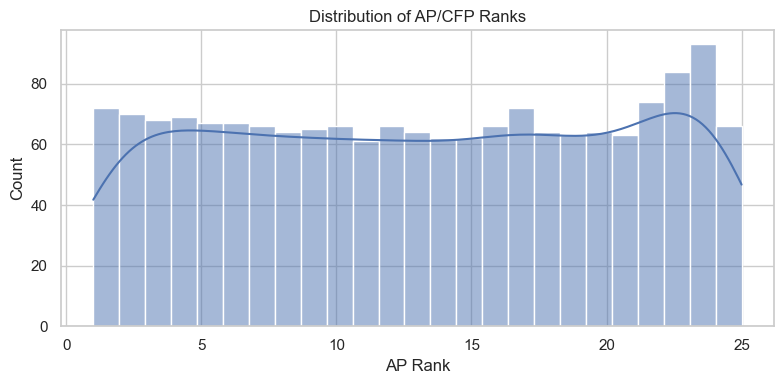

In [46]:
# 1) Distribution of AP_rank
plt.figure(figsize=(8,4))
sn.histplot(data_filtered['AP_rank'], bins=25, kde=True, color='C0')
plt.xlabel('AP Rank')
plt.ylabel('Count')
plt.title('Distribution of AP/CFP Ranks')
plt.tight_layout()
plt.show()

# Top 10 Teams by Mean AP Rank

This horizontal bar chart shows the 10 teams with the lowest average AP rank (mean of observed ranks). A lower mean indicates a team that, on average, was ranked higher across the observations in the dataset. Note that mean rank can be influenced by the number of observations per team; teams with few ranked rows may have volatile averages.

C:\Users\justi\AppData\Local\Temp\ipykernel_15832\915356609.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x='mean_AP_rank', y='Team', data=top_10_df, palette='viridis')


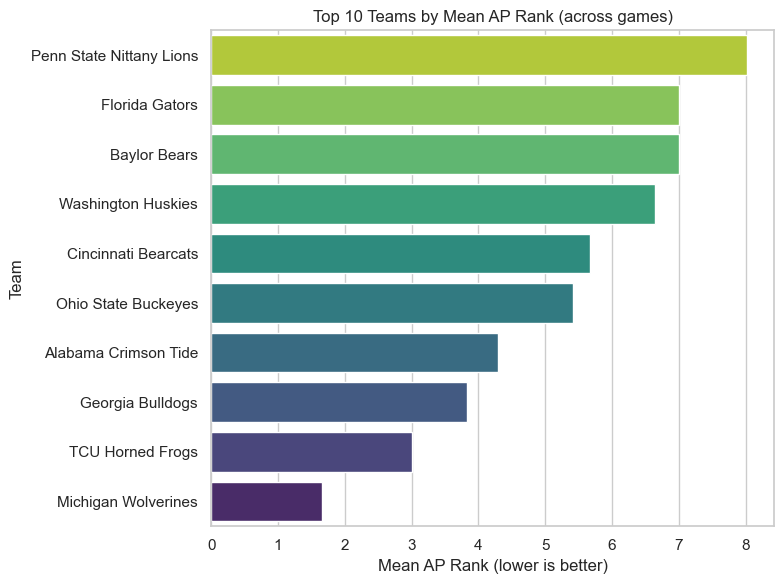

In [47]:
# 2) Top 10 teams by mean AP rank (lower is better)
mean_rank = data_filtered.groupby('Team', as_index=False)['AP_rank'].mean(numeric_only=True).dropna()
mean_rank = mean_rank.rename(columns={'AP_rank':'mean_AP_rank'})
top_10_df = mean_rank.nsmallest(10, 'mean_AP_rank')
plt.figure(figsize=(8,6))
sn.barplot(x='mean_AP_rank', y='Team', data=top_10_df, palette='viridis')
plt.xlabel('Mean AP Rank (lower is better)')
plt.title('Top 10 Teams by Mean AP Rank (across games)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# AP Rank Over Time (Top 5 Teams)

This line chart shows how the AP rank changes over time for the five teams with the most ranked observations in the dataset. The y-axis is inverted because rank 1 is the best (highest). Points are aggregated by date using the median rank to reduce duplicates when the same team has multiple rows on the same date.

Caveats:
- Dates that could not be parsed are excluded.
- If a team has very few dated observations, its line may be sparse.

C:\Users\justi\AppData\Local\Temp\ipykernel_15832\564698335.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x='num_rank1', y='Team', data=top_rank1, palette='rocket')


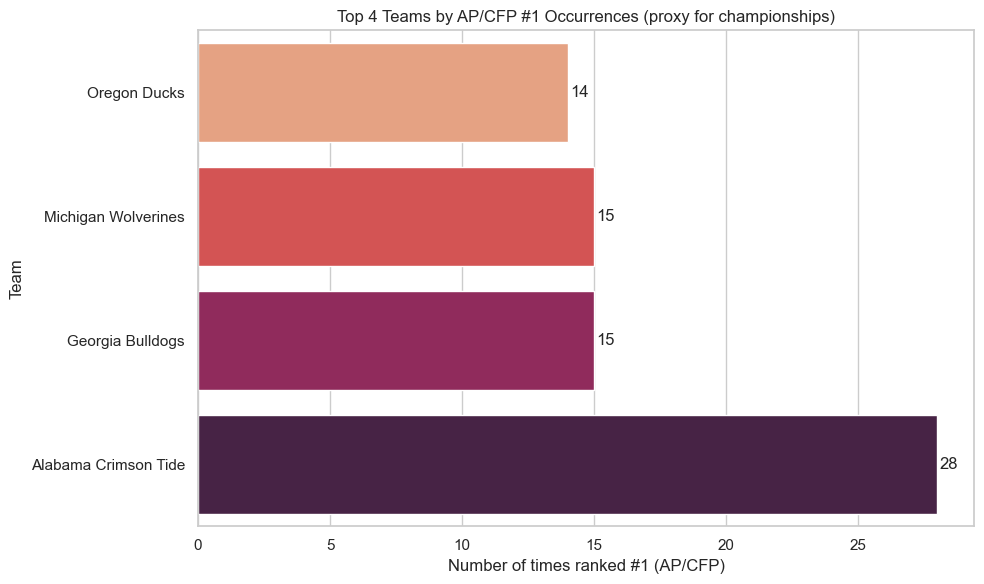

In [50]:
# 3) Most 'championships' (proxy) — teams with the most AP/CFP #1 occurrences
# NOTE: The dataset doesn't include an explicit "championship" flag. As a practical proxy
# we count how many times a team appears with AP_rank == 1 in the filtered dataset.
# This approximates how often a team reached the top poll position (useful as a proxy).

# ensure AP_rank numeric
data_filtered['AP_rank'] = pd.to_numeric(data_filtered['AP_rank'], errors='coerce')
# count occurrences of rank 1 per team
rank1_counts = (
    data_filtered.loc[data_filtered['AP_rank'] == 1]
    .groupby('Team', as_index=False)
    .size()
    .rename(columns={'size':'num_rank1'})
    .sort_values('num_rank1', ascending=False)
)

if rank1_counts.empty:
    print('No AP_rank == 1 occurrences found in the dataset; cannot create championship proxy chart')
else:
    top_n = 10
    top_rank1 = rank1_counts.head(top_n)
    plt.figure(figsize=(10,6))
    sn.barplot(x='num_rank1', y='Team', data=top_rank1, palette='rocket')
    plt.xlabel('Number of times ranked #1 (AP/CFP)')
    plt.title(f'Top {len(top_rank1)} Teams by AP/CFP #1 Occurrences (proxy for championships)')
    plt.gca().invert_yaxis()
    for i, v in enumerate(top_rank1['num_rank1']):
        plt.text(v + 0.1, i, str(int(v)), va='center')
    plt.tight_layout()
    plt.show()


# Average Point Differential by Conference

This bar chart shows the average point differential (points_scored - points_allowed) for each conference. Positive values mean teams in that conference scored more points than they allowed on average. The calculation coerces `point_differential` to numeric and ignores missing values.

Caveats:
- Conferences with few games may have less reliable averages.
- The field `point_differential` must be numeric or will be coerced to numeric (non-parsable values become missing).

C:\Users\justi\AppData\Local\Temp\ipykernel_15832\4074682155.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.barplot(x='point_differential', y='CONF', data=conf_df, palette='magma')


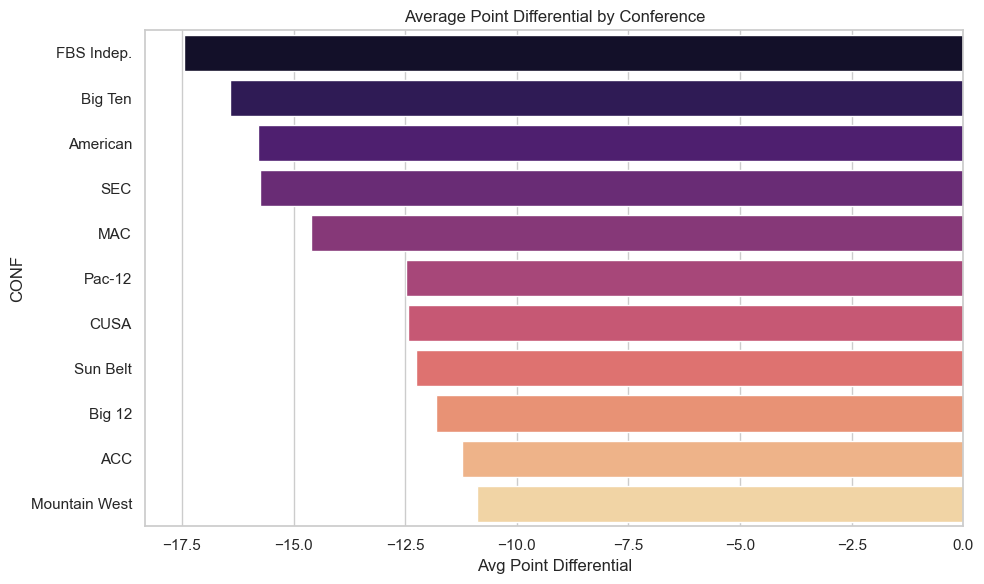

In [49]:
# 4) Average point differential by conference (additional insight)
if 'point_differential' in data_filtered.columns:
    # ensure numeric
    data_filtered['point_differential'] = pd.to_numeric(data_filtered['point_differential'], errors='coerce')
    conf_df = (
        data_filtered.groupby('CONF', as_index=False)['point_differential']
        .mean(numeric_only=True)
        .sort_values('point_differential')
    )
    plt.figure(figsize=(10,6))
    sn.barplot(x='point_differential', y='CONF', data=conf_df, palette='magma')
    plt.xlabel('Avg Point Differential')
    plt.title('Average Point Differential by Conference')
    plt.tight_layout()
    plt.show()
else:
    print('No point_differential column available for conference plot')